<a href="https://colab.research.google.com/github/mecanalpay/iot/blob/master/ram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Karınca Kolonisi Optimizasyonu ile Araç Rotalama Problemi Çözümü

Karınca Kolonisi Optimizasyonu (KKO), Marco Dorigo'nun doktora çalışması olarak 1992 yılında önerilmiş bir algoritmadır. Metasezgisel bir algoritma olan KKO, temelde yiyecek arayan bir karıncanın davranışını simüle etmeye çalışır. Karıncalar, görme yetileri fazla gelişmemiş canlılardır; geçtikleri yolları, buralara feromon adı verilen salgıları bırakarak diğerlerine haber verirler. Bu sayede üyesi oldukları koloniden başka karıncalar, besin aramaya çıktıklarında feromonun yoğun olduğu yolları tercih ederler. Karıncalar, iki kolu olan bir yol ayrımına geldiğinde, yolu bilmedikleri için rastgele hareket etseler bile kısa yoldan daha çabuk gidip geleceklerinden, bu yolda biriken feromon miktarı uzun yola kıyasla daha fazla olacaktır. Bir yoldan geçildikçe feremon yoğunluğu artacak ve geçilmeye devam edildikçe zamanla o yol, artık koloni için üzerinde mutabık olunan bir en kısa yol haline gelecektir. KKO'daki sezgisellik kısaca böyle özetlenebilir.


Karınca kolonileri, birçok çizelgeleme ve atama probleminden görüntülerde kenar tespitine kadar farklı optimizasyon problemlerinin çözümünde kullanılır. Sürü zekası yöntemleri olarak adlandırılan aileye mensup KKO'nun en sık kullanıldığı problemlerden biri Gezgin Satıcı Problemi'dir (GSP). GSP, bir satıcının/aracın gidilmesi zorunlu olan lokasyonları tekrar geçmemesi koşuluyla en kısa sürede dolaşması problemidir. Bu yazının konusu olan Araç Rotalama Problemi (ARP), GSP'ye oldukça benzer. En önemli farklılıkları, araç rotalamada birden fazla sayıda aracın bulunmasıdır. ARP'de araçlar bir ya da birden fazla sayıda depodan çıkarlar ve gidilecek müşterileri gezip genelde depoya geri dönerler. ARP'nin birçok farklı kısıtla tasarlanmış; kapasiteli, çoklu depolu, zaman kısıtlı, zaman pencereli ve dahasının farklı şekillerde bir arada olduğu versiyonları bulunur.

KKO yöntemine ve problemimize kısaca değindik. Bu yazı uygulamaya yönelik olduğundan, teorisinin detaylarına daha fazla girmeyeceğiz. Yazının amacı, KKO'nun bir rotalama problemindeki basit bir uygulamasını göstermek ve Python için yazılmış kütüphaneler sayesinde haritadan nasıl veri çekileceğine ve sonuçların nasıl görselleştirileceğine de kısaca değinmek.

## Zaman Kısıtlı Araç Rotalama Problemi

Zaman kısıtlı araç rotalama probleminde, bizim uyguladığımız şekliyle, bir seferde, yani bir rotada zaman cinsinden gidilebilecek mesafe temel kısıttır. Aynı zamanda hem gidilebilecek her yere gitmek hem de bunu az sayıda araçla yapmak istiyoruz. Zaman kısıtıyla birlikte bu model, bize ne kadar araca ihtiyacımız olduğu bilgisini oluşturduğu rota sayısı ile gösteriyor. Özetle model, belli sayıda rota oluşturarak hem gidilecek yolları sunuyor hem de ne kadar araca ihtiyacımız olduğu bilgisini bize söylemiş oluyor.

In [1]:
pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.4/99.4 kB 2.9 MB/s eta 0:00:00


In [2]:

# Haritadan veri çekerken yararlanacağımız kütüphaneler.
import osmnx as ox
import requests
import json
# Graf üstünde en kısa yolu bulmamızı sağlayacak kütüphane.
import networkx as nx
# Çeşitli hesaplamalar için algoritmamızı kodlarken kullanacağımız çok bilinen iki kütüphane.
import numpy as np
import pandas as pd
# Rotaları harita üzerinde görselleştirmek için kullanılacak kütüphane.
import folium
# Hata mesajlarını kapatmak için.
import warnings; warnings.filterwarnings("ignore");

İstenilen bölgenin detaylı yol bilgisi, açık kaynaklı bir harita platformu olan OpenStreetMap üzerinden indirildi ve kaydedildi. Haritadan veri çekilirken farklı ağ tipleri bulunuyor, sadece araçların kullanacağı yolları ya da seçtiğiniz şehirde iyi şekilde eklenmişse bisiklet yollarını veyahut tüm yol haritasını ayırt etmeksizin seçebilirsiniz. Bunları seçerken dikkat edin çünkü örneğin, araçların kullanacağı yolu seçtiğiniz durumda bazen seçtiğiniz lokasyona araçla ulaşabilmeniz mümkün olmuyor. İstanbul'da bisiklet için bir planlama yaparken de "walk" yani yürüme tipini seçmenizi tavsiye ederiz.

In [3]:
#İşlem zaman alıyor, daha önce indirilmişse tekrar indirilmesin.
try:
    G = ox.load_graphml('fatihfullwalk.graphml')
    print('Kaydedilen harita bilgisi okundu ve graf oluşturuldu.')
except:
    G = ox.graph_from_place('Fatih, Istanbul, Turkey', network_type='walk')
    ox.save_graphml(G, filepath='fatihfullwalk.graphml')
    print("Graf kaydedildi.")
    G = ox.load_graphml('fatihfullwalk.graphml')
    print('Kaydedilen harita bilgisi okundu ve graf oluşturuldu.')

Graf kaydedildi.
Kaydedilen harita bilgisi okundu ve graf oluşturuldu.


Oluşturulan graf, haritadaki biçimine benzer şekliyle görselleştirildi. Görsel üzerinde, siyah çizgiler sokak ve caddeleri; mavi noktalar ise yolların kesişim yerlerini ifade etmektedir. Bu görselleştirme, mesafe matrisini oluştururken grafın ne işe yaradığını anlamanızı kolaylaştıracaktır.

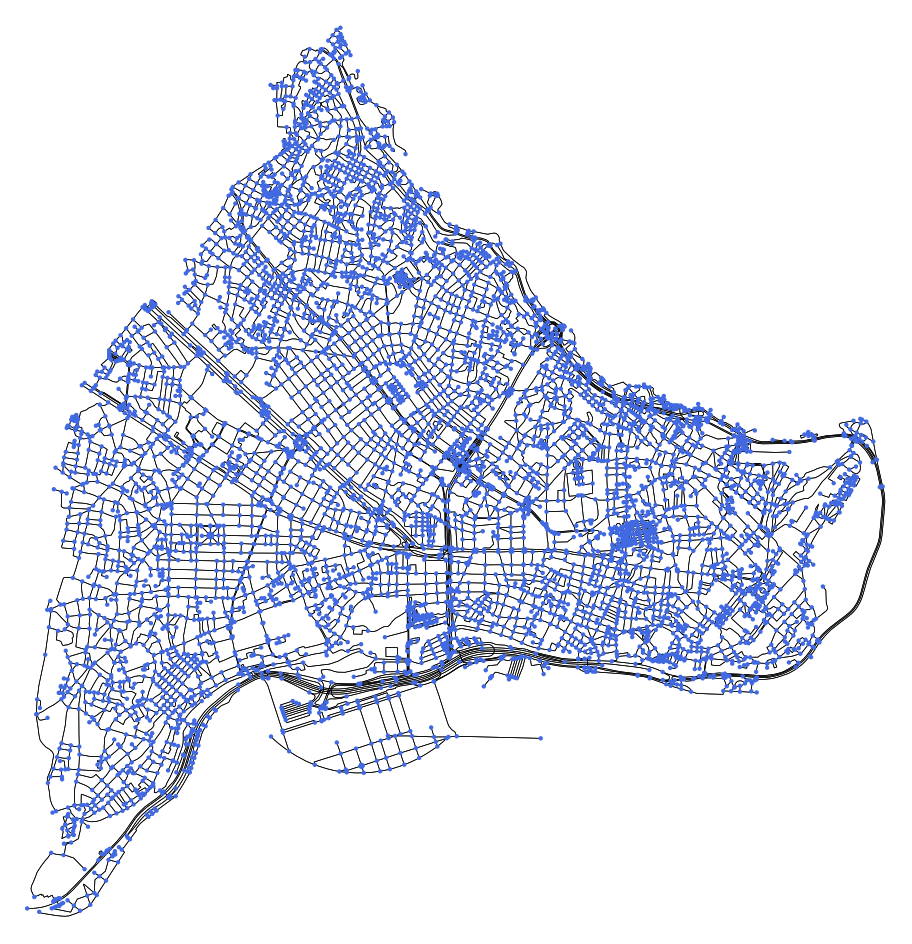

In [4]:
ox.plot_graph(G, figsize=(12, 12), edge_linewidth=0.5, bgcolor='#FFFFFF', node_color='#4169e1', edge_color='#000000', node_size=10);

Gitmek istediğimiz lokasyonların bilgilerine Overpass'e sorgu atarak ulaşacağız. Turistik bölgelerde gezilecek senaryolar düşünerek ilerlediğimden, bu iş için birçok önemli tarihi esere ve müzeye ev sahipliği yapan İstanbul'un en eski yerleşim birimlerinden olan Fatih ilçesini seçmeyi uygun gördük. Fatih ilçesindeki turistik yerlerden müze, tema parkı ve manzara etiketine sahip noktalar ile doğal ve tarihi olarak etiketlenen yerleri aşağıdaki kod bloğu ile getirip "json" formatında kaydettik.

Kafanızda daha iyi canlanması için birkaç senaryo uydurabiliriz: Bir seyahat acentesi sahibisiniz, kısıtlı zamanınız var ve fotoğrafının çekilmesini istediğiniz mekanlar var. Buralar fotoğrafçılar tarafından gezilerek fotoğraflanacak. Bu uygulama sayesinde hem ne kadar fotoğrafçıya ihtiyacınız olduğunu öğreneceksiniz hem de fotoğrafçılara hangi rotaları takip etmeleri gerektiğini söyleyebileceksiniz. İkinci bir senaryo olarak: İlk defa bir şehre gideceksiniz, mutlaka görmek istediğiniz yerler var. Buraları gezmek için kaç güne ihtiyacınız olduğunu ve hangi gün nasıl gezmeniz gerektiğini öğrenebileceksiniz.

In [5]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
area["name"="Fatih"]->.a;
(
  node["tourism"~"viewpoint|theme_park|museum"]["name"](area.a);
  node["historic"~"."]["name"](area.a);
  node["natural"~"."]["name"](area.a);
);

out center;
"""

response = requests.get(overpass_url,params={'data': overpass_query})
data = response.json()

with open('fatih.json', 'w') as outfile:
    json.dump(data, outfile)

İndirilen lokasyon bilgileri, kaydedildiği dosyadan okundu ve dosyadan okunan bilgiler, içinden uygun kısımlar alınarak sözlük veri tipinden liste tipine çevrilerek kullanılabilecek formata getirildi.

In [6]:
with open('fatih.json', 'r') as f:
    data = json.load(f)

In [7]:
all_places = [element for element in data['elements']]
print("Gidilmesi için seçilen yerlerin sayisi: " + str(len(all_places)))

Gidilmesi için seçilen yerlerin sayisi: 83


### Başlangıç Noktası / Depo Belirleyelim

Şimdi bir başlangıç noktası ekleyelim. Bu sefer Overpass'e, kütüphanesini import ederek ulaşalım. Böyle kullanmamızın nedeni sadece farklı biçimde de erişebiliyor olduğunuzu göstermek; özel bir anlamı yok. Ulaştığımız bilgilerden, kordinat ve isim bilgilerine ihtiyacımız olduğu için bunları alıp, lokasyon listesinin başına ekleyelim. Kolaylık olması için başlangıç noktası hep listenin başta olacak şekilde yazıldı.

In [8]:
pip install overpass

  Preparing metadata (setup.py) ... done
  Created wheel for osm2geojson: filename=osm2geojson-0.2.5-py3-none-any.whl size=13950 sha256=23b857585a1374f774d070445c1df3c173cbe646733be416178d5277293af56f
  Stored in directory: /root/.cache/pip/wheels/44/9d/4c/a859e0f56957a67bf06c3a5a14899205c3b1864471fcc3c2cc
Successfully built osm2geojson


In [9]:
import overpass
api = overpass.API()
resp = api.get('node["name"="Fatih Belediyesi"]')

lat, lon = resp["features"][0]["geometry"]["coordinates"][1], resp["features"][0]["geometry"]["coordinates"][0]
name = resp["features"][0]["properties"]["tags"]["name"]
depot = {"lat": lat, "lon": lon, "tags": {"name": name}}

all_places.insert(0, depot)

### Networkx and OSMNX Kütüphanelerinin Yardımıyla Mesafe Matrisini Oluşturalım

Buraya kadar yaptığımız işlemleri, büyük oranda mesafe matrisini oluşturabilmek için yaptık. Biliyorsunuz ki harita üzerinde bir noktadan diğerine, yüzlerce farklı yoldan ulaşabiliyoruz.  Mesafe matrisi, elimizdeki her bir lokasyondan bir diğerine gidilecek en kısa yolun uzunluk bilgisini veriyor. OSMNX sayesinde Fatih ilçesinin yollarının ve bu yolların kesişimlerinin bilgisini kullanarak bir graf oluşturmuş ve bunu görselleştirmiştik. Oluşturduğumuz bu grafı NetworkX kütüphanesine veriyoruz ve Dijkstra algoritmasından olası her sokağa ve caddeye bakmasını, A noktasından B noktasına ulaşmamızı sağlayacak en kısa yolu vermesini istiyoruz. Bunu gitmek istediğimiz her bir noktaya uyguladığımızda, elimizde NxN* büyüklüğünde bir mesafe matrisi oluşmuş oluyor. Bu işlemdeki hesaplama maliyeti, iki nokta etrafındaki yolların ve kesişimlerin sayısına göre değişiyor. Lokasyonların kordinatları üzerinden kuş bakışı mesafe ölçümü de yapılabilir ama bu pek isabetli sonuçlar vermez; bu çalışmadaki haliyle tek tek yolların uzunlukları toplanarak daha hassas bir ölçüm yapılmış oluyor.

_N: Gidilecek yer sayısı._

In [10]:
import osmnx as ox
import networkx as nx
import numpy as np

places = []
nearest_nodes = []
for place in all_places:
    point = (place["lat"], place["lon"])
    places.append(place["tags"]["name"])

    # En yakın düğümü bulmak için nearest_nodes kullanılıyor
    nearest = ox.distance.nearest_nodes(G, point[1], point[0])  # lon, lat sırasına dikkat!

    nearest_node = G.nodes[nearest].copy()
    nearest_node["name"] = place["tags"]["name"]
    nearest_node["osmid"] = nearest  # Düğüm ID'sini osmid olarak saklıyoruz
    nearest_nodes.append(nearest_node)

# Mesafe matrisini oluşturma
distance_matrix = []
for source_node in nearest_nodes:
    distance_row = []
    for target_node in nearest_nodes:
        distance = 0
        if source_node['osmid'] != target_node['osmid'] and nx.has_path(G, source_node['osmid'], target_node['osmid']):
            distance = nx.shortest_path_length(G, source_node['osmid'], target_node['osmid'], weight='length', method='dijkstra')
        elif source_node['osmid'] == target_node['osmid']:
            distance = 0
        else:
            distance = np.inf
        distance_row.append(distance)
    distance_matrix.append(distance_row)

distance_matrix = np.array(distance_matrix)


Bu noktada, bazı insanların kafasının karıştığını fark ettik; Karınca Kolonisi Algoritması ile kısa yolu buluyorsak bu mesafe matrisine neden ihtiyacımız vardı? Mesafe matrisinde elde ettiğimiz uzunluklar, yalnızca yolların uzunluğu baz alınarak hesaplanan kesin sonuçlar. Ancak KKO ile aslında farklı bir problem çözüyoruz ve çok farklı şekilde çözüyoruz. KKO, iki temel bilgiden yararlanıyor: Biri ortam bilgisi, yani uzaklık; diğeri feremon bilgisi, yani olasılıksal hareket edildiğinde geçilen yerlerde bırakılan kimyasal izler. KKO, bu iki bilginin bizim istediğimiz oranlardaki bileşiminden faydalanarak karar veriyor. Çözdüğü problem ise bir sıralama/dizilim problemi. Bir lokasyondan diğerine hangi sokaklardan geçilerek gidileceği ile değil, lokasyonlardan hangi sırayla geçileceği ile ilgileniyor. Ayrıca bu kararları verirken, eğer varsa farklı olarak birçok kısıtı da kontrol ediyor.

Biraz daha somutlaştırarak anlatmak gerekirse, gidilmesini istediğimiz 10 farklı lokasyon olduğunu düşünelim. Hepsine ulaşımın mümkün olduğu durumda ve hepsinden yalnız bir kere geçilmesi önkoşuluyla, bu lokasyonlar 10!, yani 3.628.800 farklı şekilde dolaşılabilir ya da başka bir deyişle dizilebilir oluyor. KKO'nun çözdüğü problem, bizim uygulamamızda tam olarak bu. KKO içerdiği sezgisellik sayesinde belli bir hata payıyla, tüm bu olasılıklara bakmak zorunda olmadan bir rota, bir çözüm sunuyor. Bu çözüm, kesin bir en iyi çözüm değil ancak yeterince iyi olduğunu varsayıyoruz.

### Mesafe -> Zaman

Burada, matrisleri tahmini hıza bölerek mesafe matrisini zaman matrisine dönüştüreceğiz çünkü kısıtımız dakika cinsinden.

* Tahmini Ortalama Araç Hızı: 40km/h  --> 667 m/min
* Tahmini Ortalama Bisiklet Hızı: 10km/h --> 167 m/min
* Tahmini Ortalama Yaya Hızı: 4km/h --> 67 m/min

_1km/h -> 16.67meter/minutes_

"create_environment" ile algoritmada kullanacağımız feremon ve ortam bilgisi matrisini oluşturuyoruz.

In [11]:
kmh_to_meterpermin = 167 #10km/h, bisiklet hızı

time_matrix = distance_matrix/kmh_to_meterpermin
places = np.array(places)

In [12]:
def create_environment(time_matrix, cities, eps = 0.0001):
    N =len(cities)

    def pheremon_matrix(cities, eps = eps):
        N =len(cities)
        data = (np.ones((N,N))- np.eye(N)) / (N-1)
        phe = pd.DataFrame(data=data, columns = cities, index = cities)
        # Aynı isimlerin hatalı şekilde haritaya birden fazla kez eklendiği durumlarda tekrarı önlemek için.
        return phe.loc[~phe.index.duplicated(),~phe.columns.duplicated()]

    env = pd.DataFrame(time_matrix, columns = cities, index = cities)

    return env.loc[~env.index.duplicated(),~env.columns.duplicated()], pheremon_matrix(cities)

env, phe = create_environment(time_matrix = time_matrix, cities = places)

### Verilerin indirilmesi ve hazırlanması ile ilgili bölüm tamamlandı. Şimdi önce karınca ve koloni sınıflarını, daha sonra bu sınıfları kullanacak olan Time Dependent Vehicle Routing Problem (TDVRP) sınıfını yazalım.

## Karınca Sınıfı

Karınca sınıfı, feremon ve mesafe matrisi, başlangıç noktası, algoritmanın temel parametrelerinden olan alfa ve beta, zaman kısıtı ve gidilen yerlerde geçirilecek ortalama zaman bilgisi parametrelerine ve beş adet metoda sahip. Bunlardan "cost" metodu, zaman cinsinden maliyet bilgisini hesaplıyor. "move" metodu, karıncanın bir birimlik adımından sorumlu. "go" metodu, tüm noktalar gezilene dek "move" metodunu çağırmakla görevli. "deposit", koloni sınıfındaki "deposit" metodu için rota bilgisini döndürüyor. "outlier"dan kasıt ise, gidip gelme süresi limit olarak belirlenen sürenin dışına çıkan ya da gidilecek uygun yolu bulunmayan noktalar; bu metot böyle yerleri listeden çıkartıyor ve en sonda göstermek için "outliers" listesine ekliyor.

In [13]:
class Ant():
    def __init__(self, env, phe,
                 start = nearest_nodes[0]['name'],
                alpha = 1, beta = 1, time_constraint = 600, time_spent = 30):

        self.outliers = []
        self.time_constraint = time_constraint
        self.time_spent = time_spent

        self.phe  = phe
        self.env = self.outlier(env)

        self.alpha, self.beta = alpha, beta
        self.cities = list(self.env.columns)
        self.current_city = start
        self.depot = start

        self.route = [self.current_city]

        self.possible_cities = self.cities.copy()
        self.possible_cities.remove(self.current_city)

    @staticmethod
    def cost(route, time_spent,en):
        result = 0
        for i in range(len(route)-1):
            result += en.loc[route[i], route[i+1]]
        result+= en.loc[route[len(route)-1],route[0]] + (len(route)-2)*time_spent

        return result

    def move(self):
        """
        Move one step
        """

        if len(self.possible_cities) == 0:
            return

        distances = self.env.loc[self.current_city][self.possible_cities]
        pheremons = self.phe.loc[self.current_city][self.possible_cities]

        distances[distances == 0] = 1

        preferences = pheremons**self.alpha/distances**self.beta
        probabilities = preferences/preferences.sum()
        probabilities.dropna(inplace=True)

        self.current_city = np.random.choice(a = probabilities.index,
                                             size=1,
                                             p = probabilities.values)[0]

        self.route.append(self.current_city)
        self.possible_cities.remove(self.current_city)


        temp_route = np.array(self.route)
        current_depot = np.where(temp_route == self.depot)[0][-1]

        cnt = Ant.cost(self.route[current_depot:], self.time_spent, self.env)

        if cnt > self.time_constraint:

            self.route.pop()
            self.possible_cities.append(self.current_city)

            cnt = Ant.cost(self.route[current_depot:], self.time_spent, self.env)

            if cnt < self.time_constraint:
                self.route.append(self.depot)
                self.current_city = self.depot
            else:
                return


    def go(self):
        """
        Build route/path
        """
        while len(self.possible_cities) != 0:
            self.move()


    def deposit(self):
        return self.route

    # Outlier is mean there is no way or it is too far to go within the specified time.
    def outlier(self, en):
        control = []
        for i,_ in enumerate(en.index.values):
            cost_temp = Ant.cost([en.index[0],en.index[i]], self.time_spent,en)
            if type(cost_temp) == pd.core.series.Series:
                control.append(cost_temp[0])
            else:
                control.append(cost_temp)

        control_np = np.array(control)

        out = en.index.values[control_np>self.time_constraint]

        self.outliers.append(out)

        en = en.drop(out, axis=1)
        en = en.drop(out, axis=0)

        return en

## Karınca Kolonisi Sınıfı

Koloni sınıfı, karıncaların koşturulduğu ve feremon değerlerinin güncellendiği, kaç karıncanın kaç defa dolaşacağını belirleyen sınıftır.

In [14]:
class AntColony():
    def __init__(self, time_matrix,
                 cities, start = nearest_nodes[0]['name'], time_constraint = 600, time_spent = 30):

        self.cities = cities
        self.start = start
        self.env, self.phe = create_environment(time_matrix, cities = cities)
        self.time_constraint = time_constraint
        self.time_spent = time_spent

    def evaporation(self, decay = 0.05):
        # Evaporation of Pheromon
        self.phe = self.phe * (1 - decay)

    def deposit(self, route, delta = 1):
        self.env[self.env == 0] = 10**-6
        for i,j in zip(route[:-1], route[1:]):
            self.phe.loc[i, j] +=  delta/self.env.loc[i, j]

    def run(self, K = 40, time = 10):
        # In each time step
        for t in range(time):
            # K ants exist in the colony
            self.colony = [Ant(env = self.env, phe = self.phe,
                          start= self.start, alpha=1, beta=1, time_constraint = self.time_constraint, time_spent = self.time_spent)
                      for k in range(K)]

            # Distributed and paralel moves of K ants
            for k in range(K):
                self.colony[k].go()

            # After independent moves, ants deposit pheremon
            for k in range(K):
                path = self.colony[k].deposit()
                self.deposit(route = path)

            self.evaporation()

## TDVRP Sınıfı

Zaman kısıtlı araç rotalama problemi sınıfı, sürüyü koşturur ve en iyi değerleri belirleyerek rota ve zaman bilgilerini yazdırır.

In [15]:
class TimeDepentendVRP():
    def __init__(self, Swarm, K, Time):

        self.swarm = Swarm
        self.swarm.run(K,Time)

    def getSwarm(self):
        return self.swarm


    def printDetails(self, routes, routes_cost, outliers):
        count = 1
        for a,i in zip(routes,routes_cost):
            print("Vehicle " + str(count) + ": " + str(a) + " = " + str(round(i,3)) + " Minutes", end='\n\n')
            count+=1
        print("Total Time: " + str(round(np.sum(routes_cost),3)) + " Minutes", end='\n\n')
        print("Outliers: " + str(outliers))


    def getResult(self, getAsDataFrame = True):
        results_dist = [Ant.cost(a.route, a.time_spent, a.env) for a in self.swarm.colony]

        min_result_index = np.argmin(results_dist)

        best_routes = np.array(self.swarm.colony[min_result_index].route)

        outliers = np.array(self.swarm.colony[min_result_index].outliers[0])
        start = self.swarm.colony[min_result_index].depot


        depot_points = np.where(best_routes == self.swarm.start)[0]


        route_ranges = [range(depot_points[i],depot_points[i+1]) for i in range(len(depot_points)-1)]


        route_ranges.append(range(depot_points[-1],len(best_routes)))

        routes = [best_routes[route_ranges[i]].tolist() for i in range(len(route_ranges))]

        [routes[i].append(start) for i in range(len(routes))]

        routes_cost = [Ant.cost(routes[i][:-1], self.swarm.colony[min_result_index].time_spent, self.swarm.colony[min_result_index].env) for i in range(len(routes))]

        self.printDetails(routes, routes_cost, outliers)

        if getAsDataFrame == True:
            return pd.DataFrame([routes, routes_cost]).T

In [16]:
daily_limit_of_work = 600 # 60dakika x 10saat -> Günlük zaman sınırını ifade ediyor.
time_spent = 30 # Gidilen her yerde ortalama 30dk geçirileceğini varsayalım.
swarm = AntColony(time_matrix, cities = places, start = nearest_nodes[0]['name'], time_constraint = daily_limit_of_work, time_spent = time_spent)

VRP = TimeDepentendVRP(swarm, 40, 10)
df = VRP.getResult()

Vehicle 1: ['Fatih Belediyesi', 'Fatih Sultan Mehmet Anıtı', 'Fethiye Müzesi', 'pudKA | Handmade Natural Soap & Cosmetics Store', 'Yanbol sinagog', 'Ebuzer Gifari Türbesi', 'İvaz Efendi Çeşmesi', 'Eğrikapı', 'Seyyit Velayet Türbesi', 'Rezan Has Museum', 'Şeyh Ahmet Buhara Türbesi', 'Zeyrek Sarnıcı', 'İstanbul’un Orta Noktası', 'III. Mustafa Türbesi', 'Molla Hüsrev cami Turbası', 'Türk Eczacılık Tarihi İhtisas Müzesi', 'Beyazit Kulesi', 'Roofstar Bosphorus', 'Karababa Türbesi', 'Fatih Belediyesi'] = 598.945 Minutes

Vehicle 2: ['Fatih Belediyesi', 'Zindan baba Türbesi', 'Hatice Turhan Sultan Türbesi', 'Manifaturaci Draper', 'Hamal', 'İstanbul Demiryolu Müzesi', 'Atatürk', 'Lions Rug and kilims Art Gallery', 'İslam bilim ve teknoloji tarihi müzesi', 'Terrace', 'Yerebatan Sarnıcı', 'Milyon Taşı', 'Halı Müzesi', 'Sultan Ahmet Vakti', 'Sahabe-i Kiramdan Abdurrahman Şami Türbesi', 'Cesme', 'Hodjapasta', 'Tasciri Spettacolo', 'PTT Müzesi', 'Fatih Belediyesi'] = 585.245 Minutes

Vehicle 3: ['F

## Şimdi Sonuçları Harita Üzerinde Gösterelim

"name_to_index" fonksiyonu, isimleri başta kullandığımız sırasıyla indislere çevirmemizi, bu şekilde haritada doğru lokasyonları göstermemizi sağlıyor. Diğer iki fonksiyon ise yolları ve lokasyonların ikonlarını harita üzerinde farklı renklerde göstermek için kullanılıyor.

In [17]:
def name_to_index(df,places):
    solution_routes = []
    for a in df[0]:
        df_np = np.array(a[:-1]).copy()
        solution_route = []
        for i in df_np:

            list_place = np.where(places == i)[0]
            if len(list_place) == 1:
                solution_route.append(list_place[0])
            elif len(list_place) > 1:
                splits = np.split(list_place,len(list_place))
                for u in splits:
                    solution_route.append(u.tolist()[0])
        solution_routes.append(solution_route.copy())

    return solution_routes

solution_routes = name_to_index(df,places)

In [18]:
def get_route_color(index):
    colors = ['#FF0000','#0000FF','#008000','#800080','#FFA500','#8B0000','#FFCCCB','#F5F5DC','#00008B','#006400','#5F9EA0',
              '#4B0082','#FFC0CB','#ADD8E6','#20B2AA','#808080','#D3D3D3']
    return colors[index%len(colors)]

def get_icon_color(index):
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred','lightred', 'beige',
              'darkblue', 'darkgreen', 'cadetblue', 'darkpurple', 'pink', 'lightblue', 'lightgreen', 'gray', 'lightgray']
    return colors[index%len(colors)]

Haritadaki noktaların kordinatlarının medyanını alarak, oluşturulan haritanın ilk andaki odak bölgesini belirliyoruz. Daha sonra ikonları ve bu ikonlarda yazacak metinlerle birlikte yolları harita üstüne basıyoruz. En son kaydedilen "html" dosyasının çıktısını "IFrame" metoduyla alıyoruz. Notebook içerisinde görüntülediğiniz haritada dilediğiniz gibi yakınlaşıp uzaklaşabilirsiniz. Her bir rotanın yolları ve rota üzerindeki noktalara ait ikonların renkleri uyumlu olacak şekilde ayarlandı. Başlangıç noktasının rengi sabit olacak şekilde siyah bırakıldı.

In [19]:
coords_median = np.median([(nearest_nodes[index]["y"], nearest_nodes[index]["x"]) for index in range(len(nearest_nodes))], axis=0)
m = folium.Map(location=coords_median.tolist(), zoom_start=12)

route_color = 0
for solution_route in solution_routes:
    order = 0
    for index in solution_route:
        if order == 0:
            popup_title = '<h3><strong>'+ "Depot:" +'</strong> '+str(nearest_nodes[index]["name"])+ '</h3>'
            tooltip = popup_title
            folium.Marker(
                [nearest_nodes[index]["y"], nearest_nodes[index]["x"]],
                popup=popup_title,
                tooltip=tooltip,
                icon=folium.Icon(color='black')
            ).add_to(m)
        else:
            popup_title = '<h3><strong>' +"Route "  + str(route_color+1) + " - Order " +str(order)+':</strong> '+str(nearest_nodes[index]["name"])+ '</h3>'
            tooltip = popup_title
            folium.Marker(
                [nearest_nodes[index]["y"], nearest_nodes[index]["x"]],
                popup=popup_title,
                tooltip=tooltip,
                icon=folium.Icon(color=get_icon_color(route_color))
            ).add_to(m)

        order += 1

    counter = 0
    while counter < len(solution_route)-1:
        source_index = solution_route[counter]
        target_index = solution_route[counter+1]

        if nearest_nodes[source_index]['osmid'] != nearest_nodes[target_index]['osmid']:
            route = nx.shortest_path(G, nearest_nodes[source_index]['osmid'], nearest_nodes[target_index]['osmid'])
            folium.PolyLine(
                locations=[(G.nodes[node]['y'], G.nodes[node]['x']) for node in route],
                color=get_route_color(route_color),
                opacity=0.5
            ).add_to(m)

        counter += 1
    route_color += 1

m.save('Routes.html')
print("Harita oluşturuldu. Routes.html olarak kaydedildi.")


Harita oluşturuldu. Routes.html olarak kaydedildi.


In [20]:
from google.colab import files
files.download('/content/Routes.html')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Tüm bunlar, karınca kolonileri ile nispeten basit bir araç rotalama problemi çözerken, problemin kodlanması, veri çekmek ve görselleştirmeye dair basit bir örnek sunmak içindi. Sizler bu algoritmayı, çok farklı şekilde ve kısıtlarla kodlayabilirsiniz; ortalama harcanan zaman yerine her noktada harcanan zamanı farklılaştırıp liste şeklinde verebilir, her rotaya farklı depo atayabilirsiniz. Lokasyonlar için uygun erişim saatlerini ekleyip bunlarla eşleşip eşleşmediğini kontrol edebilir, rotaları tek bir haritada göstermek yerine bölerek ayrı ayrı gösterebilir ve dahasını deneyebilirsiniz. Umarım keyifli ve bir şeyler öğrenebildiğiniz bir yazı olmuştur.

## Kaynaklar

Overpass, OSMNX kütüphaneleriyle yapılan ön işlemler -> https://github.com/eyildiz/osmnx-route-planner/blob/master/route_planner.ipynb

KKO, Uzay Çetin -> https://github.com/uzay00/CMPE373/blob/master/2020/3%20KarincaKolonisi/KarincaKolonisiv4.ipynb